In [ ]:
# Import data

In [1]:
import torch

In [2]:
use_cuda = False # GPU seems to raise erros on my side

device = torch.device('cuda' if use_cuda and torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cpu


In [4]:
from data_utils import get_mnist, build_data_loaders
train_dataset, test_dataset = get_mnist(normalize=True)
train_dataset.data.mean(0).mean().item(), test_dataset.data.mean(0).mean().item()


(-7.328089801639237e-10, 0.002495675580576062)

In [ ]:
# Tuning Hyperparameters

In [5]:
from ray import tune
from net import Net
import numpy as np 
import pandas
from minibatch import minibatch_run, minibatch_tune

In [6]:
from ray.tune.suggest.bayesopt import BayesOptSearch
space = {
            "lr": tune.uniform(1e-4, 1e-1),
            "b_size": tune.uniform(2, 128),
            "dec_lr": tune.uniform(0, 1)
        }
samples = 5

In [7]:
tune_net = Net().to(device)
criterion = torch.nn.CrossEntropyLoss()
bayesopt = BayesOptSearch(metric="mean_accuracy", mode="max")

In [ ]:
best_config, best_result = minibatch_tune(tune_net, train_dataset, test_dataset, samples, criterion, space, bayesopt, device)

In [ ]:
### Best Config was:
best_config

In [8]:
## Defaults that work
epochs = 10
batch_size = 16
learning_rate = 0.001
decreasing_lr = False

In [ ]:
## From Tuning
epochs = 10
batch_size = int(best_config["b_size"])
learning_rate = best_config["lr"]
decreasing_lr = best_config["dec_lr"]

In [ ]:
if decreasing_lr < 0.5:
    print("Best Result was {:.2f}% with a Batch Size of {} and a fixed learning rate of {:.4f}".format(best_result*100, batch_size, learning_rate))
else:
    print("Best Result was {:.2f}% with a Batch Size of {} and a learning rate of {:.4f} that was decreasing".format(best_result*100, batch_size, learning_rate))

In [ ]:
# Training and Testing under Normal Conditions

In [9]:
from training import accuracy
from torch.nn import CrossEntropyLoss

In [10]:
from net import Net
net_naive = Net().to(device)

In [11]:
train_loader, test_loader = build_data_loaders(train_dataset, test_dataset, batch_size)
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([16, 1, 28, 28]) torch.Size([16])


In [12]:
### Test

In [13]:
from training import training, testing
from minibatch import MiniBatchOptimizer

mini_opt = MiniBatchOptimizer(net_naive.parameters(), lr=learning_rate, decreasing_lr=decreasing_lr)

In [14]:
import matplotlib.pyplot as plt

In [15]:
losses, acc = training(net_naive, train_loader, mini_opt, criterion, accuracy, epochs=epochs, device=device)

Launching training on cpu
batch 100	loss = 2.277	acc = 0.1875
batch 200	loss = 2.237	acc = 0.375
batch 300	loss = 2.178	acc = 0.5625
batch 400	loss = 2.134	acc = 0.6875
batch 500	loss = 2.119	acc = 0.5
batch 600	loss = 2.142	acc = 0.5
batch 700	loss = 1.996	acc = 0.5
batch 800	loss = 1.79	acc = 0.625
batch 900	loss = 1.859	acc = 0.6875
batch 1000	loss = 1.644	acc = 0.6875
batch 1100	loss = 1.541	acc = 0.625
batch 1200	loss = 1.585	acc = 0.5625
batch 1300	loss = 1.324	acc = 0.625
batch 1400	loss = 0.9021	acc = 0.875
batch 1500	loss = 0.9173	acc = 0.8125
batch 1600	loss = 0.7561	acc = 0.9375
batch 1700	loss = 1.006	acc = 0.6875
batch 1800	loss = 0.5347	acc = 0.9375
batch 1900	loss = 0.6873	acc = 0.75
batch 2000	loss = 0.5378	acc = 0.9375
batch 2100	loss = 0.7953	acc = 0.75
batch 2200	loss = 0.6226	acc = 0.875
batch 2300	loss = 0.2096	acc = 1.0
batch 2400	loss = 0.3969	acc = 0.9375
batch 2500	loss = 0.4769	acc = 0.875
batch 2600	loss = 0.3818	acc = 0.875
batch 2700	loss = 0.2568	acc = 1.0

Avg loss = 0.06425441516260616	Avg acc = 0.9793


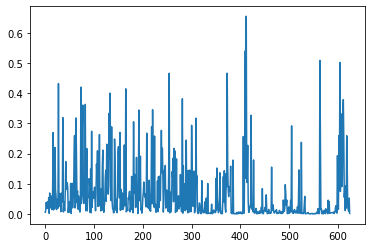

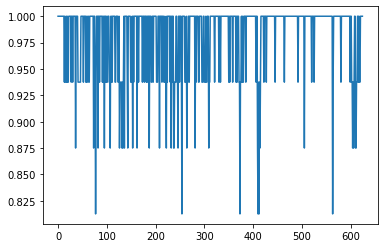

In [16]:
losses, acc = testing(net_naive, test_loader, criterion, accuracy, device=device)
plt.plot(losses)
plt.show()
plt.plot(acc)
plt.show()

In [ ]:
#net_compact = Net().to(device)

In [ ]:
# losses, accs = minibatch_run(net_compact, train_dataset, test_dataset, criterion, accuracy, device=device, bz=batch_size, lr=learning_rate, epochs=epochs, dec_lr=decreasing_lr)
# Has the weird shaping issue

In [ ]:
## Plot of losses

In [ ]:
plt.plot(losses)
plt.show()
plt.plot(acc)
plt.show()

In [ ]:
# Attack against Unprotected Model

In [17]:
from adversary import attack, protect

In [23]:
accuracies_lenet= []
examples_lenet = []

epsilons_lenet = np.arange(0, 0.5, 0.05)

In [24]:
epsilons_lenet

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45])

In [ ]:
### Attack the model with different epsilons

In [25]:
for eps in epsilons_lenet:
    acc, ex = attack(net_naive, criterion, test_loader, update_max_norm=eps, device=device)
    accuracies_lenet.append(acc)
    examples_lenet.append(ex)

Epsilon: 0.00	Test Accuracy = 0.919
Epsilon: 0.05	Test Accuracy = 0.907
Epsilon: 0.10	Test Accuracy = 0.891
Epsilon: 0.15	Test Accuracy = 0.872
Epsilon: 0.20	Test Accuracy = 0.844
Epsilon: 0.25	Test Accuracy = 0.810
Epsilon: 0.30	Test Accuracy = 0.768
Epsilon: 0.35	Test Accuracy = 0.709
Epsilon: 0.40	Test Accuracy = 0.631
Epsilon: 0.45	Test Accuracy = 0.539


In [ ]:
### Plot Results of Attacks

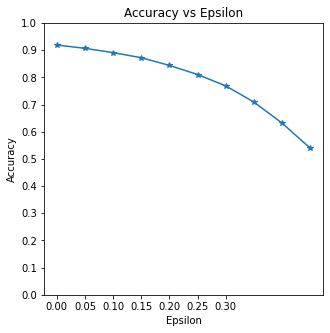

In [27]:
plt.figure(figsize=(5,5))
plt.plot(epsilons_lenet, accuracies_lenet, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Protect Model against FGSM

In [30]:
robust_net = Net().to(device)
protect_epochs = 10
protect_lr = 0.01
protect_bz = 16
protect_dec_lr = False

In [38]:
prot_train_loader, prot_test_loader = build_data_loaders(train_dataset, test_dataset, protect_bz)
mini_opt = MiniBatchOptimizer(robust_net.parameters(), lr=protect_lr, decreasing_lr=protect_dec_lr)

In [35]:
#(model: Module, optim: Optimizer,criterion: Module, train_loader: Iterable, test_loader: Iterable, device, epochs: int = 10):
robust_net = protect(robust_net, mini_opt, criterion, prot_train_loader, prot_test_loader, device=device, epochs=protect_epochs)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [20, 1, 5, 5], but got 6-dimensional input of size [16, 1, 1, 1, 28, 28] instead

In [39]:
robust_net

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [40]:
for epoch in range(protect_epochs):
        # Train an epoch
        #robust_net.train()
        for batch_x, batch_y in prot_train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass for adversarial perturbations
            batch_x.requires_grad = True
            output = robust_net(batch_x)

            original_predictions = output.argmax(1) # get the index of the max logit
            original_accuracy = accuracy(output, batch_y)
            loss = criterion(output, batch_y)
            robust_net.zero_grad()
            loss.backward()
            perturbed_data = fgsm(batch_x, batch_x.grad, 0.25)
            
            # Evaluate the network (forward pass)
            prediction = robust_net(perturbed_data)
            loss = criterion(prediction, batch_y)
            
            # Compute the gradient
            mini_opt.zero_grad()
            loss.backward()

            # Update the parameters of the model with a gradient step
            mini_opt.step()

        # Test the quality on the test set
        robust_net.eval()
        accuracies = []
        for batch_x, batch_y in prot_test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = robust_net(batch_x)
            accuracies.append(accuracy(prediction, batch_y))
        
        print("Epoch {:.2f} | Test accuracy: {:.5f}".format(epoch, sum(accuracies).item()/len(accuracies)))    

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [20, 1, 5, 5], but got 8-dimensional input of size [16, 1, 1, 1, 1, 1, 28, 28] instead

In [ ]:
# Attack against Protected Model

In [ ]:
accuracies_lenet_robust = []
examples_lenet_robust = []

epsilons_lenet_robust = np.arange(0, 0.5, 0.05)

In [ ]:
for eps in epsilons_lenet_robust:
    acc, ex = attack(protected_net, CrossEntropyLoss(), prot_train_loader, eps, device=device)
    accuracies_lenet_robust.append(acc)
    examples_lenet_robust.append(ex)

In [ ]:
# Comparing the models
plt.figure(figsize=(5,5))
plt.plot(epsilons_lenet, accuracies_lenet, "*-", c='blue', label='Convolutional network')
plt.plot(epsilons_lenet_robust, accuracies_lenet_robust, "*-", c='orange', label='Convolutional network (robust)')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))

plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend();